In [83]:
import numpy as np
import matplotlib.pyplot as plt

from tdwg.lib.mode_solvers import *

In [88]:
wl = 1.55 #in units of microns

n_core = 2.1376 #LN waveguide core index
n_clad = 1.444
n_sub = 3.5 #3.5 which stands for substrate

L_core = 0.7 #These lengths are all in microns
L_clad = 1.0

k0 = 2*np.pi/wl
from tdwg.lib.optical_helpers import find_modes
betaAllowedTE, betaAllowedTM = find_modes(L_core, k0, n_clad, n_core, n_clad)

neff_list = betaAllowedTM/k0

neff_ref = neff_list[0]
neff_ref

1.9421867797044123

0.42490821751707225


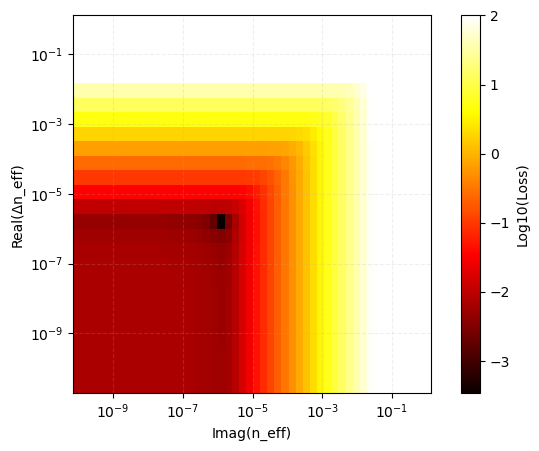

In [89]:
alpha_db_um = compute_alpha_db_stack(neff_ref, L_core, L_clad, 
                k0, n_clad, n_core, n_clad, n_sub, 
                flag_visualize=True)
alpha_db_cm = alpha_db_um*1e4
print(alpha_db_cm)

The loss here refers to the optimization problem that needs to be solved to find the mode of the waveguide. See Ryan's thesis for more detail. 


At a high level, the point that minimizes the loss function here, gives us both the change in the real part of the index and the loss, due to the presence of the substrate. 

### Now adding absorption loss to the core

The solver also supports absorption losses on top of radiation loss due to the substrate. 

We see that the loss of the mode goes up as expected. Interestingly, we see that the real part of the effective index does not get shifted due to the loss. (Expected from coupled mode theory considerations) 

29.17627367909335


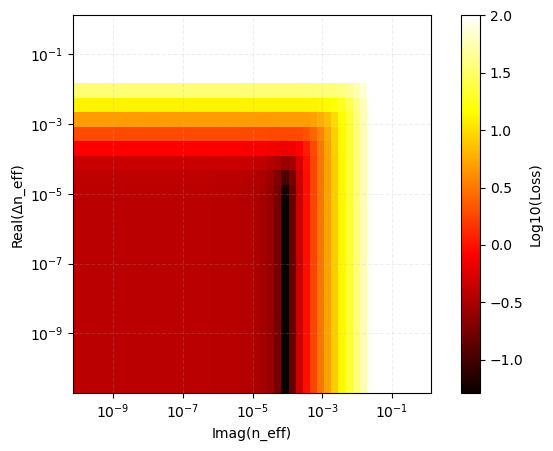

In [92]:
n_core_imag = 1e-4
n_core_with_loss = n_core + 1j*n_core_imag #NOTE: It must be positive for this work!

alpha_db_um = compute_alpha_db_stack(neff_ref, L_core, L_clad, 
                k0, n_clad, n_core_with_loss, n_clad, n_sub, 
                flag_visualize=True)
alpha_db_cm = alpha_db_um*1e4
print(alpha_db_cm)

# Perform systematic sweep

Having shown how one can use the code to solve for substrate loss, the following cells will sweep the core and clad heights.

In [52]:
L_core_list = np.linspace(0.45, 0.75, 21)
L_clad_list = np.linspace(0.9, 2, 20)

alpha_db_cm_m0_mat = np.zeros([len(L_core_list), len(L_clad_list)])
alpha_db_cm_m1_mat = np.zeros([len(L_core_list), len(L_clad_list)])

for (i, L_core) in enumerate(L_core_list):
    for (j, L_clad) in enumerate(L_clad_list):
        betaAllowedTE, betaAllowedTM = find_modes(L_core, k0, n_clad, n_core, n_clad)
        neff_list = betaAllowedTM/k0
        neff_ref = neff_list[0]

        alpha_db_um = compute_alpha_db_stack(neff_ref, L_core, L_clad, 
                        k0, n_clad, n_core, n_clad, n_sub, 
                        flag_visualize=False)
        alpha_db_cm = alpha_db_um*1e4
        alpha_db_cm_m0_mat[i,j] = alpha_db_cm
        
        if len(neff_list) == 1:
            alpha_db_cm_m1_mat[i,j] = np.nan
        else:
            neff_ref = neff_list[1]
            alpha_db_um = compute_alpha_db_stack(neff_ref, L_core, L_clad, 
                            k0, n_clad, n_core, n_clad, n_sub, 
                            flag_visualize=False)
            alpha_db_cm = alpha_db_um*1e4
            alpha_db_cm_m1_mat[i,j] = alpha_db_cm

In [58]:
import matplotlib

In [59]:
from tdwg.lib.plot_utils import *

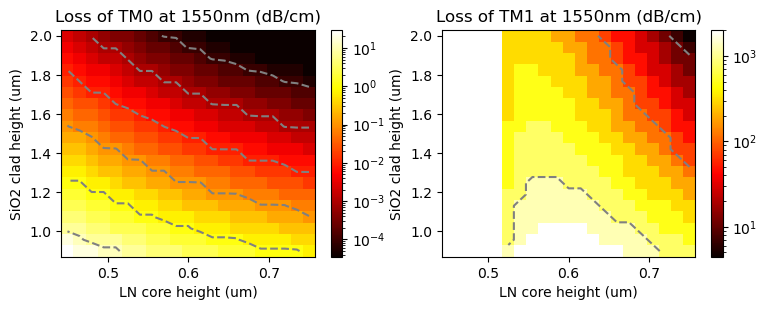

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=100)

plt.sca(axs[0])
pcolormesh_center(L_core_list, L_clad_list, alpha_db_cm_m0_mat,
              norm=matplotlib.colors.LogNorm(), cmap="hot")
plt.colorbar()

plt.contour(L_core_list, L_clad_list, alpha_db_cm_m0_mat.T,
            norm=matplotlib.colors.LogNorm(), colors="gray", linestyles="--")

plt.xlabel("LN core height (um)")
plt.ylabel("SiO2 clad height (um)")
plt.title("Loss of TM0 at 1550nm (dB/cm)")

plt.sca(axs[1])
pcolormesh_center(L_core_list, L_clad_list, alpha_db_cm_m1_mat,
              norm=matplotlib.colors.LogNorm(), cmap="hot")
plt.colorbar()

plt.contour(L_core_list, L_clad_list, alpha_db_cm_m1_mat.T,
            norm=matplotlib.colors.LogNorm(), colors="gray", linestyles="--")

plt.xlabel("LN core height (um)")
plt.ylabel("SiO2 clad height (um)")
plt.title("Loss of TM1 at 1550nm (dB/cm)")

plt.savefig("substrate loss heatmap.jpg", dpi=200, bbox_inches="tight")